In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sla

from BFGS import BFGS
from backtracking import backtracking

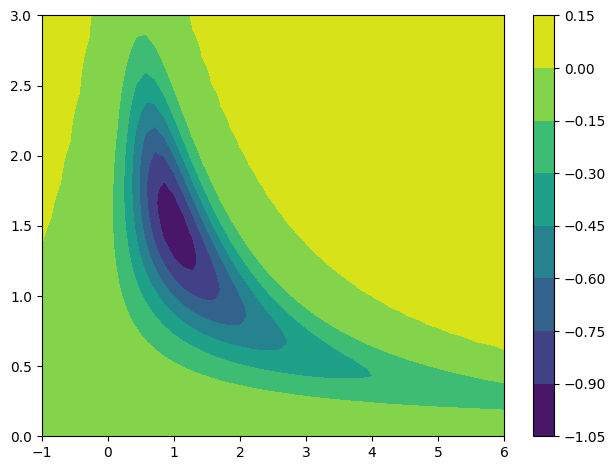

In [2]:
#define wheeler's ridge grad and hessian

def wheelerridge(x):
    x = x.reshape(-1,1)
    x0 = x[0,0]
    x1 = x[1,0]
    return -np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2) + (x0**2 + x1**2)*1e-4

def g(x):
    x = x.reshape(-1,1)
    x0 = x[0,0]
    x1 = x[1,0]
    g_x0 = np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2)*2*(x0*x1 - 3/2)*x1 + 2*x0*1e-4
    g_x1 = np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2)*2*((x0*x1 - 3/2)*x0 + (x1 - 3/2)) + 2*x1*1e-4
    return np.array([[g_x0], [g_x1]])

def Hes(x):
    x = x.reshape(-1,1)
    x0 = x[0,0]
    x1 = x[1,0]
    H00 = -x1**2*(4*x0**2*x1**2 - 12*x0*x1 + 7)*np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2) + 2*1e-4
    H01 = -((4*x0**3 + 4*x0)*x1**3 + (-12*x0**2 - 6*x0 - 6)*x1**2 + (5*x0 + 9)*x1 + 3)*np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2)
    H11 = -((4*x0**2 + 8*x0**2 + 4)*x1**2 + (-12*x0**3 - 12*x0**2 - 12*x0 - 12)*x1 + 7*x0**2 + 18*x0 + 7)*np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2) + 2*1e-4
    
    return(np.array([[H00, H01], [H01, H11]]))

x = np.linspace(-1,6)
y = np.linspace(0,3)

XX, YY = np.meshgrid(x, y)
Z = np.zeros_like(XX.flatten())
for i, (X, Y) in enumerate(zip(XX.flatten(), YY.flatten())):
    Z[i] = wheelerridge(np.array([X,Y]))

Z = Z.reshape(XX.shape)

fig, ax = plt.subplots(layout='tight')

cont = ax.contourf(XX, YY, Z)
fig.colorbar(cont)

plt.show()

[[1.19098827]
 [2.2655242 ]]


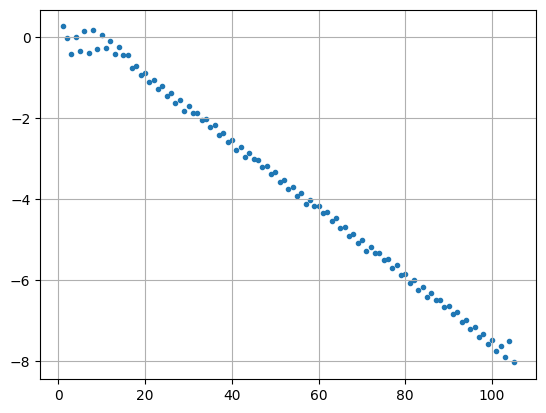

[[1.0000111 +0.j]
 [1.49991668+0.j]]


In [3]:
##Test a random point for BFGS x in [0.5,3], y in [0,3]

x0 = np.random.random((2,1)).reshape(-1,1)*np.array([[2.5],[3]]) + np.array([[0.5],[0]])
print(x0)
H = sla.inv(Hes(x0))
eigs = sla.eigvals(H)
if np.any(eigs <= 0 ): H = H - np.min(eigs)*1.1*np.eye(2,2)
sla.eigvals(H)

x, grads, _ = BFGS(x0, wheelerridge, g, H, get_step=backtracking, 
                   verbose=False, eps=1e-8, kmax=1000)

fig, ax = plt.subplots()

ax.scatter(np.arange(1,len(grads)+1), np.log10(grads), marker='.')
ax.grid()

plt.show()

print(x)